# DATA PRE-PROCESSING NOTEBOOK

### **I. Import thư viện**

In [99]:
import os
import glob
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### **II. Nối các file csv thu thập được thành một file duy nhất**

Thiết lập đường dẫn folder chứa các file csv input và tên file csv output sau khi nối

In [100]:
INPUT_FOLDER = "input"  
OUTPUT_FOLDER = "output"
RAW_FILENAME = "football_players_raw_dataset.csv"
FINAL_FILENAME = "football_players_dataset.csv"

RAW_OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, "football_players_raw_dataset.csv")
FINAL_OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, "football_players_dataset.csv")

In [101]:
def merge_csv(folder_path, output_folder, output_filename, drop_duplicate=True):
    os.makedirs(output_folder, exist_ok=True)

    output_path = os.path.join(output_folder, output_filename)

    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not all_files:
        print("Not found any CSV files in the folder.")
        return
    
    dfs = []

    for file in all_files:
        try:
            df = pd.read_csv(file)
            print(f"Loaded: {file} ({len(df)} rows)")
            dfs.append(df)
        except Exception as e:
            print(f"Read error for file {file}: {e}")

    merged_df = pd.concat(dfs, ignore_index=True)

    if drop_duplicate:
        before = len(merged_df)
        merged_df = merged_df.drop_duplicates(subset="player_id", keep="last")
        after = len(merged_df)
        print(f"Removed {before - after} duplicates")

    merged_df.to_csv(output_path, index=False)
    print(f"Merged file saved at: {output_path}")

In [102]:
merge_csv(INPUT_FOLDER, OUTPUT_FOLDER, RAW_FILENAME)

Loaded: input\A-League_Men.csv (378 rows)
Loaded: input\Allsvenskan.csv (523 rows)
Loaded: input\Argentine_Liga.csv (1274 rows)
Loaded: input\Austrian_Bundesliga.csv (390 rows)
Loaded: input\Belgian_Pro_League.csv (578 rows)
Loaded: input\Bolivian_Primera_División.csv (115 rows)
Loaded: input\Bundesliga.csv (578 rows)
Loaded: input\Canadian_Premier_League.csv (13 rows)
Loaded: input\Challenger_Pro_League.csv (515 rows)
Loaded: input\Chilean_Primera_División.csv (198 rows)
Loaded: input\Chinese_Super_League.csv (525 rows)
Loaded: input\Croatian_Football_League.csv (108 rows)
Loaded: input\Czech_First_League.csv (619 rows)
Loaded: input\Danish_Superliga.csv (159 rows)
Loaded: input\Eerste_Divisie.csv (25 rows)
Loaded: input\EFL_League_One.csv (270 rows)
Loaded: input\EFL_League_Two.csv (105 rows)
Loaded: input\Ekstraklasa.csv (2 rows)
Loaded: input\Eliteserien.csv (523 rows)
Loaded: input\Eredivisie.csv (638 rows)
Loaded: input\football_players_full_dataset.csv (20682 rows)
Loaded: input

### **III. Tiền xử lí dữ liệu**

#### **1. Đọc và khám phá dữ liệu**

In [103]:
df = pd.read_csv(RAW_OUTPUT_FILE)
print(f"\nTập dữ liệu: {df.shape[0]} players, {df.shape[1]} features")


print("\nThông tin cơ bản:")
print(f"   - Giá trị thiếu (Missing values): {df.isnull().sum().sum():,} cells")
print(f"   - Bộ nhớ sử dụng (Memory usage): {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



Tập dữ liệu: 20682 players, 70 features

Thông tin cơ bản:
   - Giá trị thiếu (Missing values): 764,870 cells
   - Bộ nhớ sử dụng (Memory usage): 19.17 MB


#### **2. Phân loại vị trí cầu thủ**


Phân bố vị trí:
   MF      : 8,136 cầu thủ ( 39.3%)
   DF      : 7,192 cầu thủ ( 34.8%)
   FW      : 3,193 cầu thủ ( 15.4%)
   GK      : 2,138 cầu thủ ( 10.3%)
   UNKNOWN :    23 cầu thủ (  0.1%)


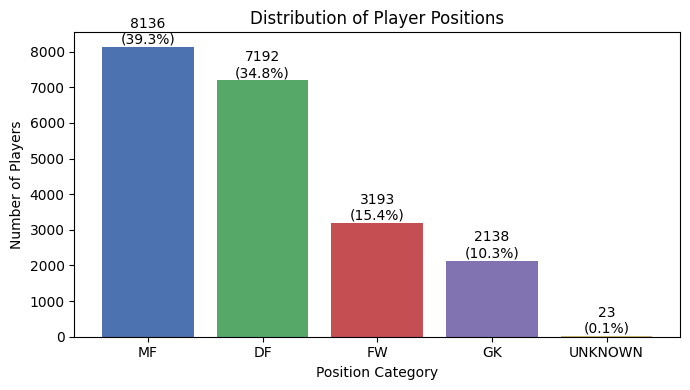

In [104]:
def classify_position(pos):
    """Phân loại vị trí cầu thủ thành 4 nhóm chính"""
    if pd.isna(pos):
        return 'UNKNOWN'
    pos = str(pos).upper()
    if 'GK' in pos:
        return 'GK'
    elif any(x in pos for x in ['DF', 'CB', 'LB', 'RB', 'WB']):
        return 'DF'
    elif any(x in pos for x in ['MF', 'CM', 'DM', 'AM']):
        return 'MF'
    elif any(x in pos for x in ['FW', 'ST', 'CF', 'LW', 'RW']):
        return 'FW'
    return 'UNKNOWN'

df['position_category'] = df['position'].apply(classify_position)

print("\nPhân bố vị trí:")
for pos, count in df['position_category'].value_counts().items():
    pct = count / len(df) * 100
    print(f"   {pos:8s}: {count:5,} cầu thủ ({pct:5.1f}%)")


# Đếm số lượng theo vị trí
counts = df['position_category'].value_counts()
percentages = counts / len(df) * 100

# Vẽ biểu đồ
plt.figure(figsize=(7, 4))
bars = plt.bar(
    counts.index,
    counts.values,
    color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
)

# Ghi chú số lượng + %
for bar, count, pct in zip(bars, counts.values, percentages.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{count}\n({pct:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xlabel("Position Category")
plt.ylabel("Number of Players")
plt.title("Distribution of Player Positions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### **3. Phân tích Missing Values**


CÁC CỘT CÓ MISSING > 5%:
--------------------------------------------------------------------------------
🔴 penalty_save_pct                             :  96.85%
🔴 avg_pass_length                              :  95.81%
🔴 wins_per90                                   :  95.81%
🔴 def_actions_outside_pen_per90                :  95.81%
🔴 goals_against_per90                          :  95.81%
🔴 shots_on_target_against_per90                :  95.81%
🔴 saves_per90                                  :  95.81%
🔴 avg_distance_def_actions                     :  95.81%
🔴 crosses_stopped_pct                          :  95.81%
🔴 clean_sheet_pct                              :  95.81%
🔴 save_percentage                              :  95.81%
🔴 draws_per90                                  :  95.81%
🔴 psxg_per_shot                                :  95.81%
🔴 psxg_ga_per90                                :  95.81%
🔴 passes_attempted_per90                       :  95.81%
🔴 losses_per90                        

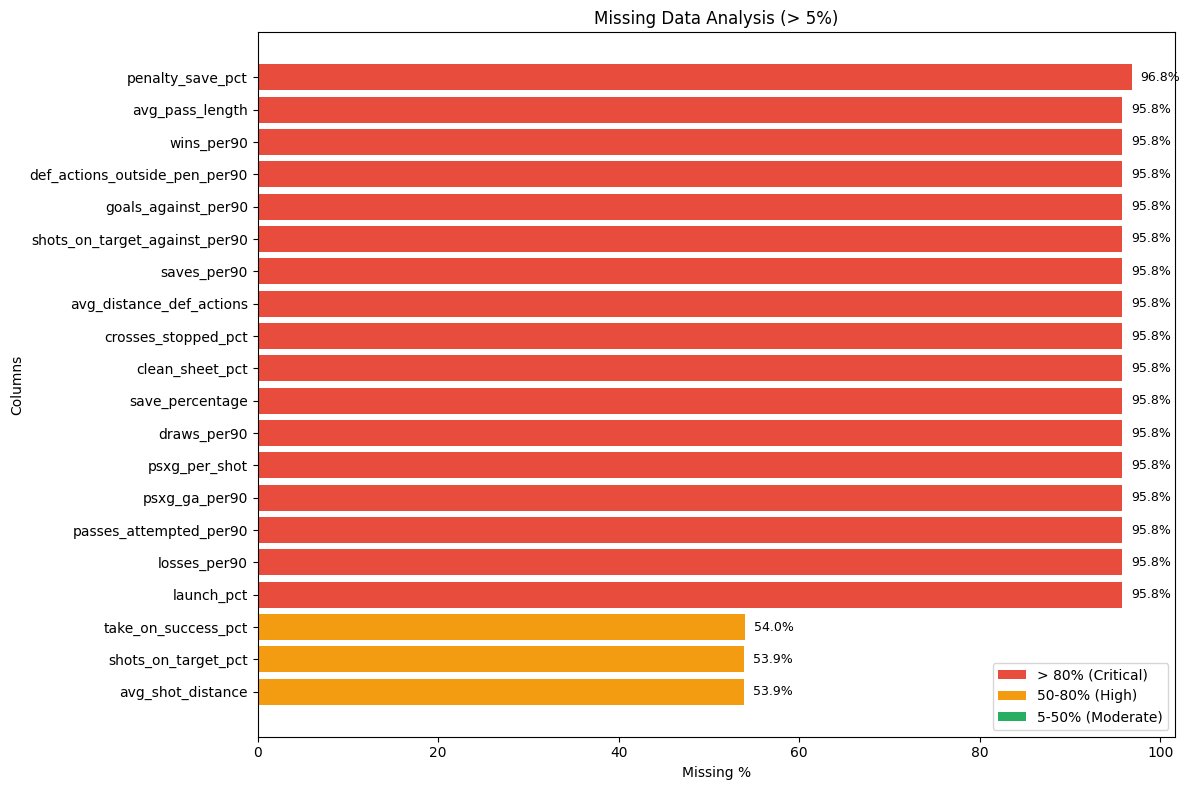

In [105]:
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Pct': (df.isnull().sum().values / len(df) * 100)
})
missing_analysis['Data_Type'] = missing_analysis['Column'].apply(lambda x: str(df[x].dtype))
missing_analysis = missing_analysis.sort_values('Missing_Pct', ascending=False)

print("\nCÁC CỘT CÓ MISSING > 5%:")
print("-" * 80)
high_missing = missing_analysis[missing_analysis['Missing_Pct'] > 5]

for idx, row in high_missing.head(20).iterrows():
    status = "🔴" if row['Missing_Pct'] > 80 else "🟡" if row['Missing_Pct'] > 50 else "🟢"
    print(f"{status} {row['Column']:45s}: {row['Missing_Pct']:6.2f}%")


high_missing = missing_analysis[missing_analysis['Missing_Pct'] > 5].head(20)

def get_color(pct):
    if pct > 80:
        return '#e74c3c'  
    elif pct > 50:
        return '#f39c12'  
    else:
        return '#27ae60'  

colors = [get_color(pct) for pct in high_missing['Missing_Pct']]

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
bars = plt.barh(high_missing['Column'], high_missing['Missing_Pct'], color=colors)

plt.xlabel('Missing %')
plt.ylabel('Columns')
plt.title('Missing Data Analysis (> 5%)')
plt.gca().invert_yaxis()  

for bar, pct in zip(bars, high_missing['Missing_Pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='> 80% (Critical)'),
    Patch(facecolor='#f39c12', label='50-80% (High)'),
    Patch(facecolor='#27ae60', label='5-50% (Moderate)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

Các cột có tỷ lệ missing > 95% chủ yếu là chỉ số đặc thù cho THỦ MÔN, chỉ xuất hiện khi cầu thủ thi đấu ở vị trí GK:

- Chỉ số cứu thua & bàn thua

   - saves_per90: Số pha cứu thua mỗi 90 phút

   - save_percentage: Tỷ lệ cứu thua

   - shots_on_target_against_per90: Số cú sút trúng đích phải đối mặt

   - goals_against_per90: Số bàn thua mỗi 90 phút

   -  clean_sheet_pct: Tỷ lệ giữ sạch lưới

- Post-shot xG & phạt đền

   - psxg_per_shot: Post-shot xG trên mỗi cú sút đối mặt

   - psxg_ga_per90: Post-shot xG bàn thua mỗi 90 phút

   - penalty_save_pct: Tỷ lệ cản phá phạt đền

- Kiểm soát không gian & bóng bổng

   - crosses_stopped_pct: Tỷ lệ chặn bóng tạt

   - def_actions_outside_pen_per90: Hành động phòng ngự ngoài vòng cấm

- Chỉ số phát động bóng (đặc thù GK)

   - avg_pass_length: Độ dài đường chuyền trung bình

   - launch_pct: Tỷ lệ phất bóng dài

   - passes_attempted_per90: Số đường chuyền mỗi 90 phút

- Kết quả trận đấu (chỉ có ý nghĩa với GK)

   - wins_per90: Thắng mỗi 90 phút

   - draws_per90: Hòa mỗi 90 phút

   - losses_per90: Thua mỗi 90 phút

Các cột này **CHỈ** có giá trị cho thủ môn (~10% dataset).

Với 90% dữ liệu là **outfield players** → missing 90%+.

Ngược lại, các chỉ số outfield (goals, assists, xG...) sẽ = 0 hoặc không có ý nghĩa với thủ môn.

→ **THỦ MÔN** và **OUTFIELD** có **BỘ CHỈ SỐ HOÀN TOÀN KHÁC NHAU**

→ Không thể train chung 1 model

Quyết định loại bỏ các cột này ra khỏi dataset. Và loại bỏ vị trí thủ môn ra khỏi mô hình, tránh ảnh hưởng đến các chỉ số của các vị trí khác.

Lý do:
   1. Features GK-specific missing 95%+ với outfield players
   2. Features outfield (goals, xG, assists) = 0 hoặc vô nghĩa với GK
   3. Thị trường chuyển nhượng thực tế cũng định giá GK và outfield 
      theo tiêu chí hoàn toàn khác nhau
   4. Nếu ép train chung → model sẽ học sai pattern

**Loại bỏ thủ môn**

In [106]:
print(f"\nTRƯỚC KHI LOẠI:")
print(f"   - Tổng samples: {len(df):,}")
print(f"   - GK: {len(df[df['position_category'] == 'GK']):,}")
print(f"   - Outfield: {len(df[df['position_category'] != 'GK']):,}")
print(f"   - Features: {len(df.columns)}")

# Loại bỏ GK
df = df[df['position_category'] != 'GK'].copy()

# Định nghĩa và drop các cột GK-specific
GK_SPECIFIC_COLS = [
    'saves_per90', 'save_percentage', 'clean_sheet_pct', 
    'goals_against_per90', 'psxg_per_shot', 'psxg_ga_per90',
    'penalty_save_pct', 'crosses_stopped_pct', 'shots_on_target_against_per90', 
    'avg_distance_def_actions', 'def_actions_outside_pen_per90', 
    'wins_per90', 'draws_per90', 'losses_per90', 
    'launch_pct', 'avg_pass_length', 'passes_attempted_per90'
]

gk_cols_dropped = [c for c in GK_SPECIFIC_COLS if c in df.columns]
df.drop(columns=gk_cols_dropped, inplace=True)

# Tạo indicator columns cho outfield
position_categories = ['DF', 'MF', 'FW']
for pos in position_categories:
    df[f'is_{pos}'] = (df['position_category'] == pos).astype(int)

print(f"\nSAU KHI LOẠI:")
print(f"   - Samples: {len(df):,}")
print(f"   - Features: {len(df.columns)}")
print(f"   - Đã drop: {len(gk_cols_dropped)} cột GK-specific")

print(f"\nPhân bố vị trí còn lại:")
for pos, count in df['position_category'].value_counts().items():
    pct = count / len(df) * 100
    print(f"   {pos}: {count:,} ({pct:.1f}%)")


TRƯỚC KHI LOẠI:
   - Tổng samples: 20,682
   - GK: 2,138
   - Outfield: 18,544
   - Features: 71

SAU KHI LOẠI:
   - Samples: 18,544
   - Features: 57
   - Đã drop: 17 cột GK-specific

Phân bố vị trí còn lại:
   MF: 8,136 (43.9%)
   DF: 7,192 (38.8%)
   FW: 3,193 (17.2%)
   UNKNOWN: 23 (0.1%)


**Tiếp tục kiểm tra Mising Values cho các vị trí còn lại**

In [107]:
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Pct': (df.isnull().sum().values / len(df) * 100)
}).sort_values('Missing_Pct', ascending=False)

print("\nCác cột có missing > 5%:")
print("-" * 80)
high_missing = missing_df[missing_df['Missing_Pct'] > 5]
for idx, row in high_missing.head(20).iterrows():
    status = "🔴" if row['Missing_Pct'] > 50 else "🟡" if row['Missing_Pct'] > 20 else "🟢"
    print(f"{status} {row['Column']:45s}: {row['Missing_Pct']:6.2f}%")


Các cột có missing > 5%:
--------------------------------------------------------------------------------
🔴 foot                                         :  52.57%
🟡 take_on_success_pct                          :  48.68%
🟡 shots_on_target_pct                          :  48.60%
🟡 avg_shot_distance                            :  48.60%
🟡 aerial_win_pct                               :  46.90%
🟡 touches_att_pen_per90                        :  46.71%
🟡 progressive_passes_per90                     :  46.71%
🟡 sca_per90                                    :  46.71%
🟡 gca_per90                                    :  46.71%
🟡 key_passes_per90                             :  46.71%
🟡 ball_recoveries_per90                        :  46.71%
🟡 pass_completion_pct                          :  46.71%
🟡 passes_into_final_third_per90                :  46.71%
🟡 passes_into_penalty_area_per90               :  46.71%
🟡 progressive_passes_rec_per90                 :  46.71%
🟡 touches_att_third_per90             

Các cột có missing > 50% không đủ dữ liệu để phân tích:
   - Impute quá nhiều giá trị sẽ tạo ra data giả
   - Model sẽ học từ pattern không thực tế
   - Ảnh hưởng đến độ tin cậy của kết quả

**Loại bỏ các cột có missing > 50%**

In [108]:
cols_to_drop_missing = missing_df[missing_df['Missing_Pct'] > 50]['Column'].tolist()

if cols_to_drop_missing:
    print("Loại bỏ các cột có missing > 50%")

    print(f"\n   HÀNH ĐỘNG: Drop {len(cols_to_drop_missing)} cột")
    print("-" * 80)
    for col in cols_to_drop_missing:
        pct = missing_df[missing_df['Column'] == col]['Missing_Pct'].values[0]
        print(f"    {col}: {pct:.1f}%")
    
    df.drop(columns=[c for c in cols_to_drop_missing if c in df.columns], inplace=True)
    print(f"\nDataset sau khi drop: {df.shape}")
else:
    print("\nKhông có cột nào missing > 50%")

Loại bỏ các cột có missing > 50%

   HÀNH ĐỘNG: Drop 1 cột
--------------------------------------------------------------------------------
    foot: 52.6%

Dataset sau khi drop: (18544, 56)


### **4 Xử lí Target Missing**

In [109]:
target_missing = df['market_value'].isna().sum()
target_missing_pct = target_missing / len(df) * 100

print(f"\nPHÂN TÍCH:")
print(f"   - market_value missing: {target_missing:,} ({target_missing_pct:.1f}%)")
print(f"   - market_value có giá trị: {len(df) - target_missing:,}")


PHÂN TÍCH:
   - market_value missing: 3,567 (19.2%)
   - market_value có giá trị: 14,977


**market_value** là BIẾN MỤC TIÊU (target variable) cần dự đoán.

KHÔNG ĐƯỢC PHÉP **IMPUTE target variable** vì:
   1. Impute = tạo ra giá trị giả cho chính biến cần dự đoán
   2. Model sẽ học từ data không thực tế
   3. Evaluation metrics sẽ không phản ánh đúng hiệu năng

Các dòng không có market_value = không có label → không dùng được

**Loại bỏ các dòng không có market_value**

In [110]:
if target_missing > 0:
    before_count = len(df)
    df = df.dropna(subset=['market_value']).copy()
    after_count = len(df)
    
    print(f"\n   HÀNH ĐỘNG:")
    print(f"   - Đã loại bỏ: {before_count - after_count:,} dòng")
    print(f"   - Dataset còn lại: {after_count:,} samples")
else:
    print("\nKhông có dòng nào thiếu market_value")


   HÀNH ĐỘNG:
   - Đã loại bỏ: 3,567 dòng
   - Dataset còn lại: 14,977 samples


#### **5. Phân tích Correlation - Phát hiện trùng lặp**

In [111]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['market_value', 'is_DF', 'is_MF', 'is_FW']
numeric_cols_for_corr = [c for c in numeric_cols if c not in exclude_cols]

corr_matrix = df[numeric_cols_for_corr].corr()

print("\nCÁC CẶP CỘT CÓ CORRELATION > 0.95:")
print("-" * 80)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.95:
            high_corr_pairs.append({
                'Column_1': corr_matrix.columns[i],
                'Column_2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    for item in high_corr_pairs:
        print(f"   🔴 {item['Column_1']:30s} <-> {item['Column_2']:30s}: {item['Correlation']:.4f}")
else:
    print("    Không có cặp nào correlation > 0.95")


CÁC CẶP CỘT CÓ CORRELATION > 0.95:
--------------------------------------------------------------------------------
   🔴 npxg_per90                     <-> xg_per90                      : 0.9666
   🔴 passes_completed_per90         <-> touches_per90                 : 0.9614
   🔴 carries_per90                  <-> passes_received_per90         : 0.9501


Các cột có correlation > 0.95 chứa **THÔNG TIN GẦN NHƯ GIỐNG NHAU**:
   - Gây ra **MULTICOLLINEARITY** trong model
   - Làm model khó xác định feature nào thực sự quan trọng
   - Tăng variance của coefficients
   - Có thể gây overfitting

Giải pháp: Giữ lại cột có correlation **CAO HƠN** với target (market_value)

In [112]:
if high_corr_pairs:
    # Tính correlation với target để quyết định giữ cột nào
    target_corr = {}
    for col in numeric_cols_for_corr:
        valid_data = df[[col, 'market_value']].dropna()
        if len(valid_data) > 30:
            target_corr[col] = valid_data[col].corr(valid_data['market_value'])


    cols_to_drop_duplicate = []
   
    for item in high_corr_pairs:
        col1, col2 = item['Column_1'], item['Column_2']
        corr1 = abs(target_corr.get(col1, 0))
        corr2 = abs(target_corr.get(col2, 0))
        
        to_drop = col1 if corr1 < corr2 else col2
        to_keep = col2 if corr1 < corr2 else col1
        
        if to_drop not in cols_to_drop_duplicate:
            cols_to_drop_duplicate.append(to_drop)
            print(f"      Drop '{to_drop}' (corr với target: {abs(target_corr.get(to_drop, 0)):.4f})")
            print(f"      Giữ '{to_keep}' (corr với target: {abs(target_corr.get(to_keep, 0)):.4f})")
    
    df.drop(columns=[c for c in cols_to_drop_duplicate if c in df.columns], inplace=True)
    print(f"\nĐã drop {len(cols_to_drop_duplicate)} cột duplicate")
    print(f"   Dataset: {df.shape}")

      Drop 'npxg_per90' (corr với target: 0.1464)
      Giữ 'xg_per90' (corr với target: 0.1504)
      Drop 'touches_per90' (corr với target: 0.1110)
      Giữ 'passes_completed_per90' (corr với target: 0.1292)
      Drop 'carries_per90' (corr với target: 0.1691)
      Giữ 'passes_received_per90' (corr với target: 0.1933)

Đã drop 3 cột duplicate
   Dataset: (14977, 53)


#### **5. Phân tích Correlation với Target**

In [113]:
# Cập nhật lại danh sách cột sau khi drop
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_for_corr = [c for c in numeric_cols if c not in exclude_cols]

target_corr = {}
for col in numeric_cols_for_corr:
    valid_data = df[[col, 'market_value']].dropna()
    if len(valid_data) > 30:
        target_corr[col] = valid_data[col].corr(valid_data['market_value'])

target_corr_sorted = sorted(target_corr.items(), key=lambda x: abs(x[1]), reverse=True)

print("\n📈 TOP 15 FEATURES TƯƠNG QUAN CAO NHẤT VỚI MARKET_VALUE:")
print("-" * 80)
for i, (col, corr) in enumerate(target_corr_sorted[:15], 1):
    emoji = "📈" if corr > 0 else "📉"
    strength = "Strong" if abs(corr) > 0.5 else "Medium" if abs(corr) > 0.3 else "Weak"
    print(f"{i:2d}. {strength:6s} {emoji} {col:40s}: {corr:7.4f}")

# Tìm cột có correlation thấp
low_corr_cols = [col for col, corr in target_corr.items() if abs(corr) < 0.03]

print(f"\n📉 CÁC CỘT CÓ CORRELATION < 0.03 (gần như không liên quan):")
print("-" * 80)
for col in low_corr_cols:
    print(f"   🟢 {col:40s}: {target_corr[col]:7.4f}")


📈 TOP 15 FEATURES TƯƠNG QUAN CAO NHẤT VỚI MARKET_VALUE:
--------------------------------------------------------------------------------
 1. Weak   📈 goals                                   :  0.2579
 2. Weak   📈 assists                                 :  0.2420
 3. Weak   📈 minutes_played                          :  0.2026
 4. Weak   📈 appearances                             :  0.1955
 5. Weak   📈 passes_received_per90                   :  0.1933
 6. Weak   📈 touches_att_pen_per90                   :  0.1878
 7. Weak   📈 npxg_xag_per90                          :  0.1865
 8. Weak   📈 gca_per90                               :  0.1777
 9. Weak   📈 touches_att_third_per90                 :  0.1768
10. Weak   📈 npg_per90                               :  0.1636
11. Weak   📈 xag_per90                               :  0.1623
12. Weak   📈 progressive_carries_per90               :  0.1621
13. Weak   📈 sca_per90                               :  0.1606
14. Weak   📈 xg_per90                      

Các cột có |correlation| < 0.03 với market_value:
   - Gần như KHÔNG CÓ MỐI QUAN HỆ TUYẾN TÍNH với target
   - Không đóng góp nhiều vào việc dự đoán
   - Có thể gây nhiễu (noise) cho model
   - Tăng dimensionality không cần thiết

Lưu ý: Một số cột có thể có quan hệ PHI TUYẾN với target
→ Cân nhắc giữ lại nếu có lý do domain knowledge

In [114]:
if low_corr_cols:
    print(f"\n   HÀNH ĐỘNG: Drop {len(low_corr_cols)} cột")
    print("-" * 80)
    for col in low_corr_cols:
        print(f"    {col}: correlation = {target_corr[col]:.4f}")
    
    df.drop(columns=[c for c in low_corr_cols if c in df.columns], inplace=True)
    print(f"\nDataset sau khi drop: {df.shape}")


   HÀNH ĐỘNG: Drop 6 cột
--------------------------------------------------------------------------------
    height: correlation = 0.0285
    assists_per_90: correlation = 0.0077
    take_on_success_pct: correlation = -0.0283
    tackles_per90: correlation = -0.0251
    aerial_win_pct: correlation = -0.0072
    red_cards_per90: correlation = -0.0268

Dataset sau khi drop: (14977, 47)


### **7. Cột tính toán từ cột khác**

In [115]:
derived_candidates = []

# Check minutes_per_game = minutes_played / appearances
if all(col in df.columns for col in ['minutes_per_game', 'minutes_played', 'appearances']):
    calculated = df['minutes_played'] / df['appearances'].replace(0, 1)
    valid = pd.DataFrame({
        'original': df['minutes_per_game'],
        'calculated': calculated
    }).dropna()
    
    if len(valid) > 10:
        corr = valid['original'].corr(valid['calculated'])
        if abs(corr) > 0.99:
            derived_candidates.append({
                'column': 'minutes_per_game',
                'formula': 'minutes_played / appearances',
                'correlation': corr
            })

# Check npxg_xag_per90 = npxg_per90 + xag_per90
if all(col in df.columns for col in ['npxg_xag_per90', 'npxg_per90', 'xag_per90']):
    calculated = df['npxg_per90'] + df['xag_per90']
    valid = pd.DataFrame({
        'original': df['npxg_xag_per90'],
        'calculated': calculated
    }).dropna()
    
    if len(valid) > 10:
        corr = valid['original'].corr(valid['calculated'])
        if abs(corr) > 0.95:
            derived_candidates.append({
                'column': 'npxg_xag_per90',
                'formula': 'npxg_per90 + xag_per90',
                'correlation': corr
            })

Các cột derived (tính toán từ cột khác) chứa THÔNG TIN TRÙNG LẶP:
   - minutes_per_game = minutes_played / appearances
   - npxg_xag_per90 = npxg_per90 + xag_per90

Vấn đề:
   - Thông tin đã có trong các cột gốc
   - Gây ra multicollinearity
   - Không thêm giá trị dự đoán mới

Giữ lại các cột gốc vì chúng mang ý nghĩa rõ ràng hơn.

In [116]:
if derived_candidates:
    print("\nCÁC CỘT DERIVED ĐƯỢC PHÁT HIỆN:")
    print("-" * 80)
    for item in derived_candidates:
        print(f"   ✓ {item['column']} = {item['formula']} (corr: {item['correlation']:.4f})")

   
    cols_to_drop_derived = [item['column'] for item in derived_candidates]
    print(f"\n   HÀNH ĐỘNG: Drop {len(cols_to_drop_derived)} cột")
    print("-" * 80)
    for item in derived_candidates:
        print(f"    {item['column']} (= {item['formula']})")
    
    df.drop(columns=[c for c in cols_to_drop_derived if c in df.columns], inplace=True)
    print(f"\nDataset sau khi drop: {df.shape}")
else:
    print("\nKhông phát hiện cột derived rõ ràng")


CÁC CỘT DERIVED ĐƯỢC PHÁT HIỆN:
--------------------------------------------------------------------------------
   ✓ minutes_per_game = minutes_played / appearances (corr: 1.0000)

   HÀNH ĐỘNG: Drop 1 cột
--------------------------------------------------------------------------------
    minutes_per_game (= minutes_played / appearances)

Dataset sau khi drop: (14977, 46)


### **8. Metadata Column - Các cột không cần cho model**

In [117]:
metadata_cols = ['player_id', 'player_name', 'foot', 'position', 'position_category']
metadata_in_df = [c for c in metadata_cols if c in df.columns]

print("\nCÁC CỘT METADATA TRONG DATASET:")
print("-" * 80)
for col in metadata_in_df:
    print(f"   - {col}")


print(f"\n   HÀNH ĐỘNG: Drop {len(metadata_in_df)} cột")
print("-" * 80)
for col in metadata_in_df:
    print(f"    {col}")

df.drop(columns=[c for c in metadata_in_df if c in df.columns], inplace=True)
print(f"\nDataset sau khi drop: {df.shape}")


CÁC CỘT METADATA TRONG DATASET:
--------------------------------------------------------------------------------
   - player_id
   - player_name
   - position
   - position_category

   HÀNH ĐỘNG: Drop 4 cột
--------------------------------------------------------------------------------
    player_id
    player_name
    position
    position_category

Dataset sau khi drop: (14977, 42)


Các cột metadata KHÔNG NÊN dùng cho modeling:

   - player_id: Mã định danh, không có ý nghĩa dự đoán
   - player_name: Tên cầu thủ, không nên dùng (data leakage)
   - foot: Chân thuận - ít ảnh hưởng đến giá trị
   - position: Đã được encode thành is_DF, is_MF, is_FW
   - position_category: Tương tự, đã encode

Lưu ý: nationality, current_club, league sẽ được giữ lại
và encode riêng trong bước modeling.

### **9. Phân tích VIF (Multicollinearity)**

VIF > 100 cho thấy MULTICOLLINEARITY CỰC CAO:
   - Các cột này có thể được dự đoán gần như hoàn hảo từ cột khác
   - Gây ra instability trong model coefficients
   - Có thể dẫn đến overfitting

Tuy nhiên, với tree-based models (RF, XGBoost, LightGBM):
   - Multicollinearity ÍT ẢNH HƯỞNG hơn so với linear models
   - Có thể giữ lại và để model tự chọn features quan trọng

In [118]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['market_value', 'is_DF', 'is_MF', 'is_FW']
cols_for_vif = [c for c in numeric_cols if c not in exclude_cols]
cols_for_vif = [c for c in cols_for_vif if df[c].isnull().sum() / len(df) < 0.3][:25]

df_vif = df[cols_for_vif].dropna()

if len(df_vif) > 100 and len(cols_for_vif) > 1:
    print(f"\nTính VIF trên {len(df_vif):,} samples với {len(cols_for_vif)} features")
    print("-" * 80)
    
    try:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = cols_for_vif
        vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                          for i in range(len(cols_for_vif))]
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        print("\nTOP 10 VIF CAO NHẤT:")
        for idx, row in vif_data.head(10).iterrows():
            if row['VIF'] > 100:
                status = "🔴🔴"
            elif row['VIF'] > 50:
                status = "🔴  "
            elif row['VIF'] > 10:
                status = "🟡  "
            else:
                status = "✅  "
            print(f"{status} {row['Feature']:40s}: {row['VIF']:10.2f}")
        
        # Kiểm tra có cột VIF > 100 không
        very_high_vif = vif_data[vif_data['VIF'] > 100]['Feature'].tolist()
        
        if very_high_vif:         
            print("="*80)
            print("QUYẾT ĐỊNH: Giữ nguyên (tree-based models robust với multicollinearity)")
            print("="*80)
        else:
            print("\n✅ Không có cột nào có VIF cực cao (>100)")
            
    except Exception as e:
        print(f"WARNING: Không thể tính VIF: {str(e)}")
else:
    print("WARNING: Không đủ dữ liệu để tính VIF")



Tính VIF trên 11,601 samples với 6 features
--------------------------------------------------------------------------------

TOP 10 VIF CAO NHẤT:
🟡   appearances                             :      26.26
🟡   minutes_played                          :      18.27
✅   age                                     :       5.77
✅   goals                                   :       2.69
✅   assists                                 :       2.26
✅   goals_per_90                            :       1.88

✅ Không có cột nào có VIF cực cao (>100)


### **10. Imputation - Xử lí Missing còn lại**

Sau khi loại bỏ các cột có missing cao, còn lại một số missing nhỏ:
   - Có thể do dữ liệu không được thu thập đầy đủ
   - Một số cầu thủ thiếu thông tin ở một vài chỉ số

Phương pháp xử lý:
   - Numeric columns: Impute bằng MEDIAN
     → Median robust với outliers (dữ liệu bóng đá thường có outliers)
   - Categorical columns: Impute bằng MODE (giá trị phổ biến nhất)

In [119]:
total_missing = df.isnull().sum().sum()
total_cells = len(df) * len(df.columns)
missing_pct = total_missing / total_cells * 100

print(f"\nPHÂN TÍCH MISSING CÒN LẠI:")
print(f"   - Total missing: {total_missing:,} cells ({missing_pct:.2f}%)")

# Chi tiết từng cột
missing_by_col = df.isnull().sum()
cols_with_missing = missing_by_col[missing_by_col > 0].sort_values(ascending=False)

if len(cols_with_missing) > 0:
    print(f"\n   Các cột còn missing:")
    for col, count in cols_with_missing.items():
        pct = count / len(df) * 100
        dtype = df[col].dtype
        print(f"   - {col}: {count} ({pct:.1f}%) - {dtype}")


# Impute numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_impute = [c for c in numeric_cols if c != 'market_value']

before_missing = df[cols_to_impute].isnull().sum().sum()

if before_missing > 0:
    imputer = SimpleImputer(strategy='median')
    df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
    print(f"   - Numeric: Imputed {before_missing} values bằng median")

# Impute categorical
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_val, inplace=True)
        print(f"   - {col}: Imputed {missing_count} values bằng mode ('{mode_val}')")

after_missing = df.isnull().sum().sum()
print(f"\nMissing sau impute: {after_missing}")


PHÂN TÍCH MISSING CÒN LẠI:
   - Total missing: 163,473 cells (25.99%)

   Các cột còn missing:
   - shots_on_target_pct: 5808 (38.8%) - float64
   - avg_shot_distance: 5808 (38.8%) - float64
   - passes_into_final_third_per90: 5482 (36.6%) - float64
   - progressive_passes_rec_per90: 5482 (36.6%) - float64
   - progressive_carries_per90: 5482 (36.6%) - float64
   - take_ons_per90: 5482 (36.6%) - float64
   - carries_into_final_third_per90: 5482 (36.6%) - float64
   - touches_att_third_per90: 5482 (36.6%) - float64
   - touches_att_pen_per90: 5482 (36.6%) - float64
   - passes_into_penalty_area_per90: 5482 (36.6%) - float64
   - passes_received_per90: 5482 (36.6%) - float64
   - interceptions_per90: 5482 (36.6%) - float64
   - blocks_per90: 5482 (36.6%) - float64
   - ball_recoveries_per90: 5482 (36.6%) - float64
   - aerials_won_per90: 5482 (36.6%) - float64
   - yellow_cards_per90: 5482 (36.6%) - float64
   - progressive_passes_per90: 5482 (36.6%) - float64
   - fouls_committed_per90

### **11. Kiểm tra dữ liệu**

In [120]:
print(f"\nDATASET CUỐI CÙNG:")
print(f"   - Samples: {len(df):,}")
print(f"   - Features: {len(df.columns)}")
print(f"   - Missing: {df.isnull().sum().sum()}")

print(f"\nTARGET (market_value):")
print(f"   - Min: {df['market_value'].min():,.2f}")
print(f"   - Max: {df['market_value'].max():,.2f}")
print(f"   - Mean: {df['market_value'].mean():,.2f}")
print(f"   - Median: {df['market_value'].median():,.2f}")

print(f"\nFEATURES:")
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"   - Numeric: {len(numeric_features)} cột")
print(f"   - Categorical: {len(cat_features)} cột → {cat_features}")

print(f"\nDANH SÁCH CỘT:")
print(df.columns.tolist())


DATASET CUỐI CÙNG:
   - Samples: 14,977
   - Features: 42
   - Missing: 0

TARGET (market_value):
   - Min: 0.01
   - Max: 200.00
   - Mean: 3.45
   - Median: 0.60

FEATURES:
   - Numeric: 39 cột
   - Categorical: 3 cột → ['nationality', 'current_club', 'league']

DANH SÁCH CỘT:
['age', 'nationality', 'current_club', 'league', 'appearances', 'minutes_played', 'goals', 'assists', 'goals_per_90', 'npg_per90', 'xag_per90', 'npxg_xag_per90', 'xg_per90', 'shots_per90', 'shots_on_target_per90', 'shots_on_target_pct', 'avg_shot_distance', 'sca_per90', 'gca_per90', 'key_passes_per90', 'passes_completed_per90', 'pass_completion_pct', 'passes_into_final_third_per90', 'passes_into_penalty_area_per90', 'progressive_passes_per90', 'progressive_passes_rec_per90', 'progressive_carries_per90', 'take_ons_per90', 'carries_into_final_third_per90', 'touches_att_third_per90', 'touches_att_pen_per90', 'passes_received_per90', 'interceptions_per90', 'blocks_per90', 'ball_recoveries_per90', 'aerials_won_per9

### **12. Export dữ liệu**

In [121]:

# Sắp xếp cột
column_order = ['age', 'nationality', 'current_club', 'league', 
                'appearances', 'minutes_played', 'is_DF', 'is_MF', 'is_FW']

other_cols = [c for c in df.columns 
              if c not in column_order and c != 'market_value']
column_order.extend(other_cols)
column_order.append('market_value')
column_order = [c for c in column_order if c in df.columns]

df_final = df[column_order]

# Tạo folder và lưu
output_folder = os.path.dirname(FINAL_OUTPUT_FILE)
if output_folder:
    os.makedirs(output_folder, exist_ok=True)

df_final.to_csv(FINAL_OUTPUT_FILE, index=False)

print(f"\nSaved to: {FINAL_OUTPUT_FILE}")
print(f"   - Rows: {len(df_final):,}")
print(f"   - Columns: {len(df_final.columns)}")


Saved to: output\football_players_dataset.csv
   - Rows: 14,977
   - Columns: 42
